First 5 rows of the dataset:
   Unnamed: 0  sensor_0  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0           0       1.0       2.0       1.0       7.0       0.0       1.0   
1           1       5.0       1.0       3.0       5.0       2.0       2.0   
2           2       3.0       1.0       4.0       3.0       4.0       0.0   
3           3       2.0       2.0       4.0       3.0       5.0       0.0   
4           4       4.0       3.0       3.0       2.0       5.0       1.0   

   sensor_6  sensor_7  sensor_8  ...  sensor_13  sensor_14  sensor_15  \
0       1.0       4.0       0.0  ...        8.0        1.0        0.0   
1       1.0       2.0       3.0  ...        4.0        5.0        5.0   
2       1.0       6.0       0.0  ...        3.0        3.0        1.0   
3       3.0       2.0       2.0  ...        4.0        1.0        1.0   
4       3.0       1.0       1.0  ...        1.0        3.0        2.0   

   sensor_16  sensor_17  sensor_18  sensor_19  parcel_0  parcel_1  pa

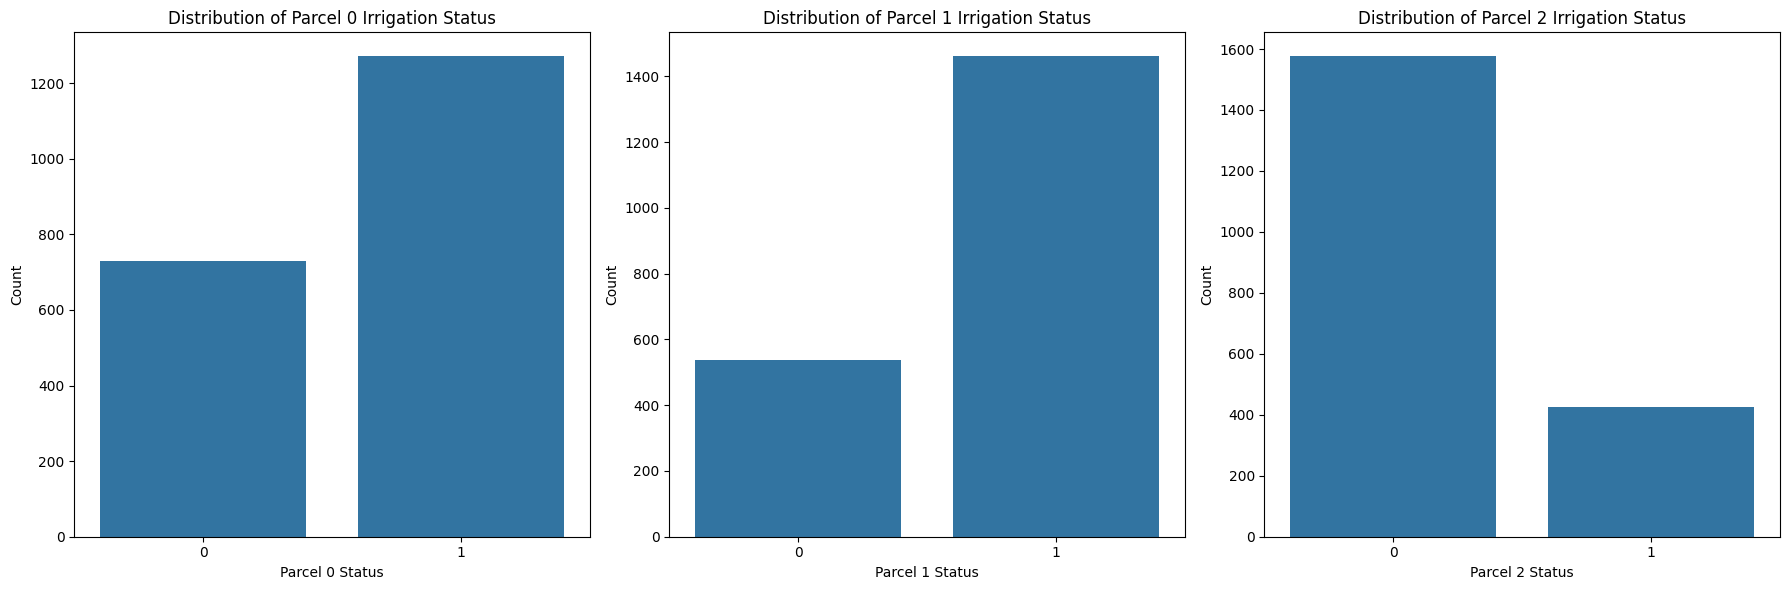


--- Sensor Data Distributions ---


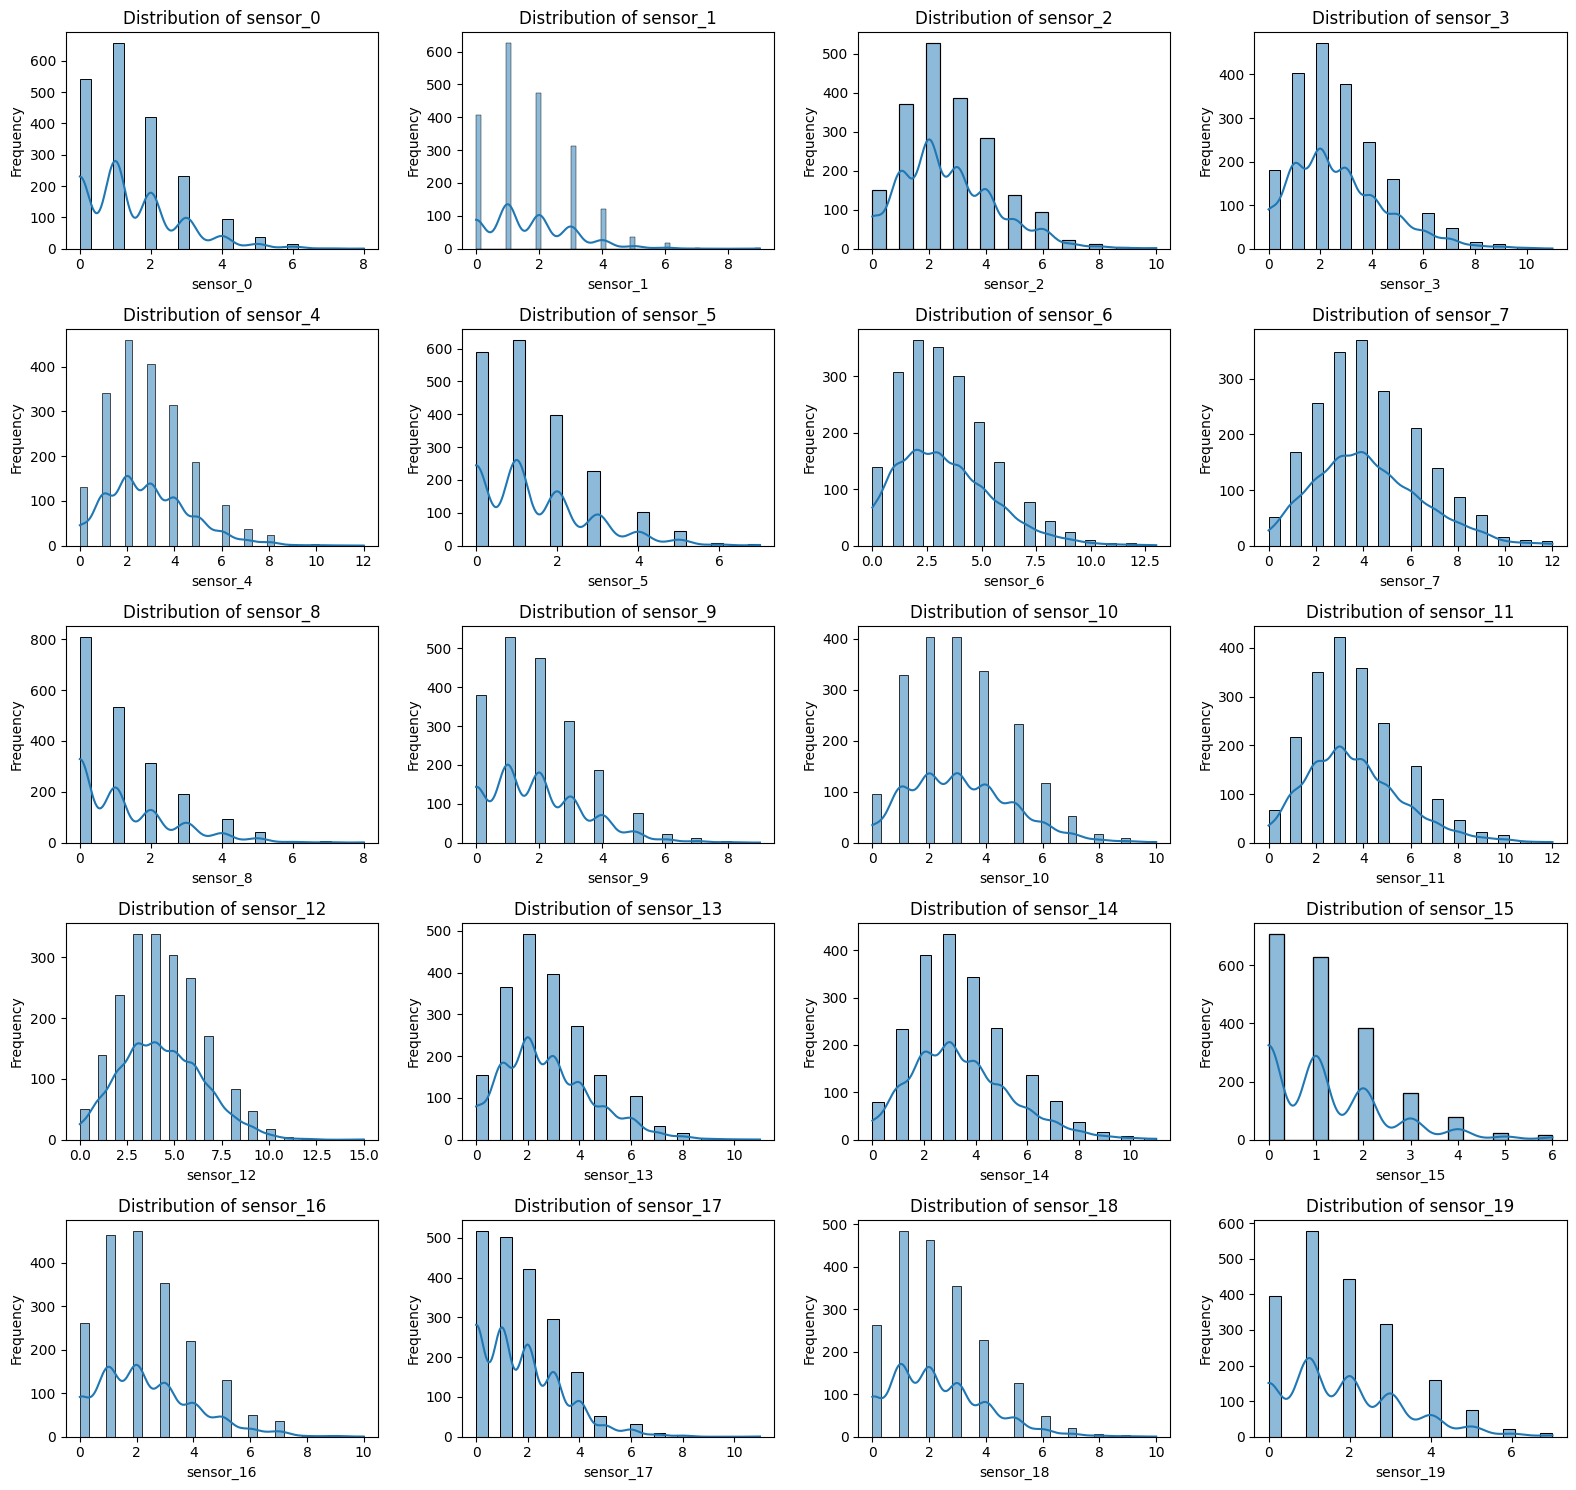

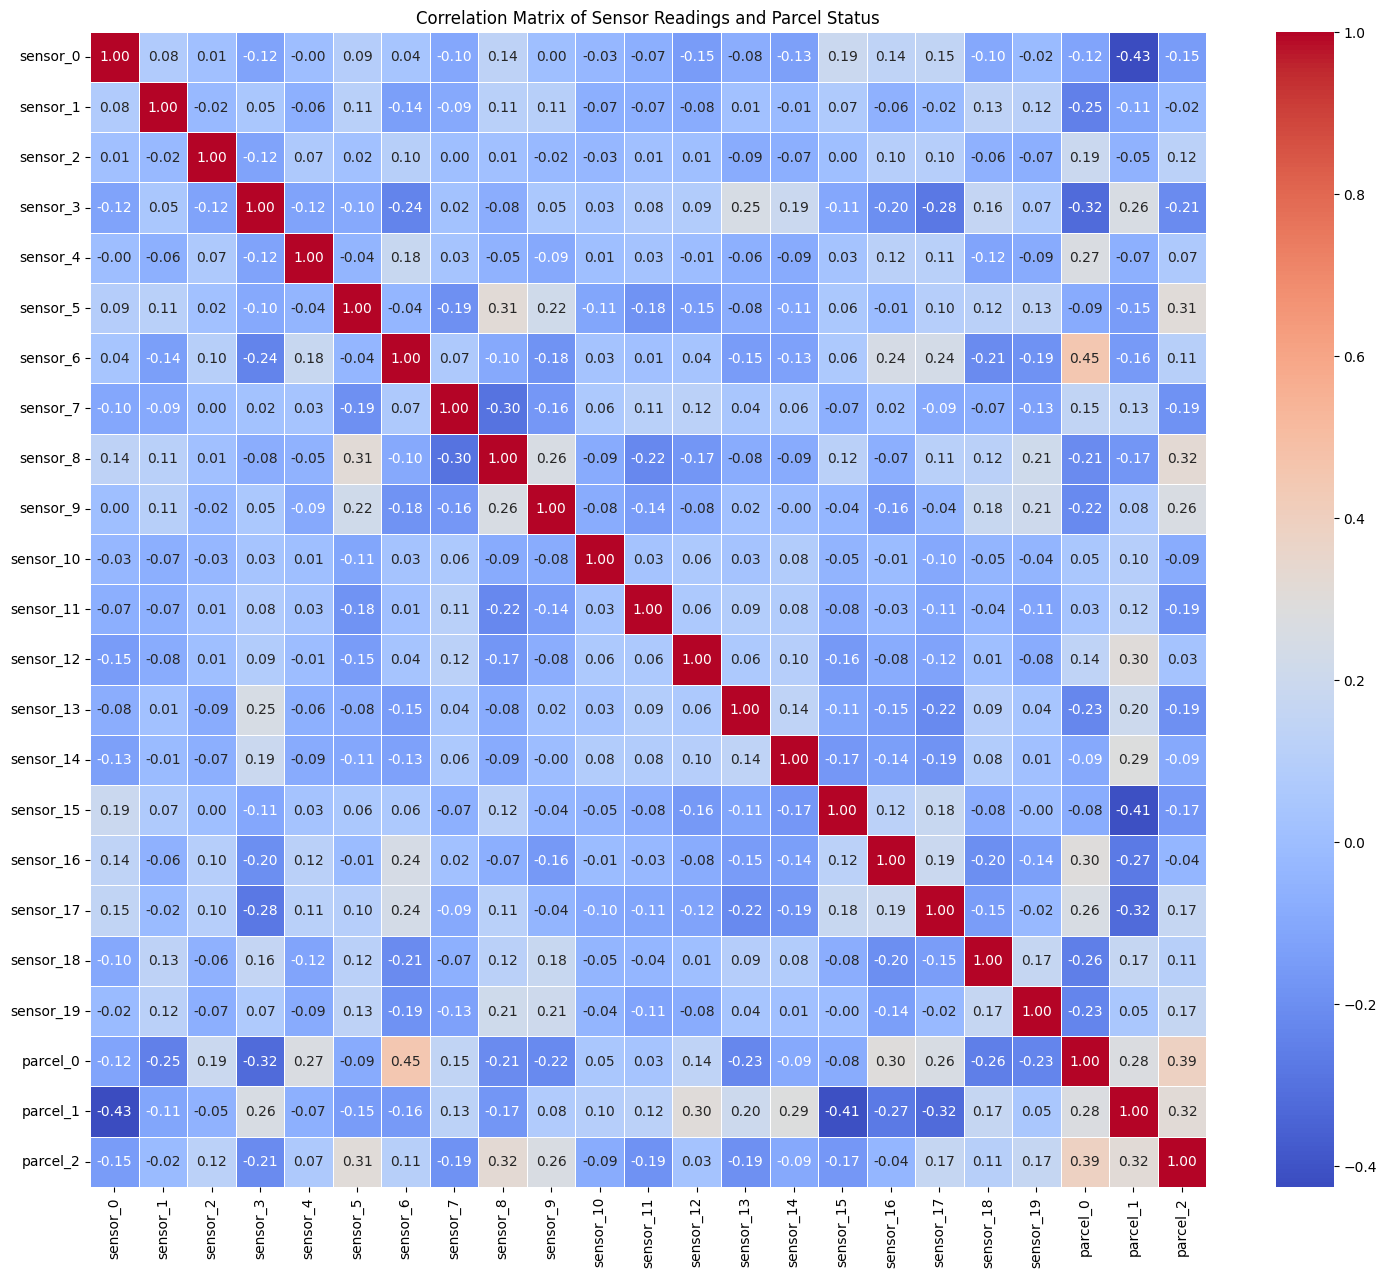


--- Model Evaluation ---
Classification Report for parcel_0:

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       144
           1       0.89      0.93      0.91       256

    accuracy                           0.88       400
   macro avg       0.88      0.86      0.87       400
weighted avg       0.88      0.88      0.88       400

--------------------------------------------------
Classification Report for parcel_1:

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        96
           1       0.91      0.96      0.93       304

    accuracy                           0.90       400
   macro avg       0.88      0.83      0.85       400
weighted avg       0.89      0.90      0.89       400

--------------------------------------------------
Classification Report for parcel_2:

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       31

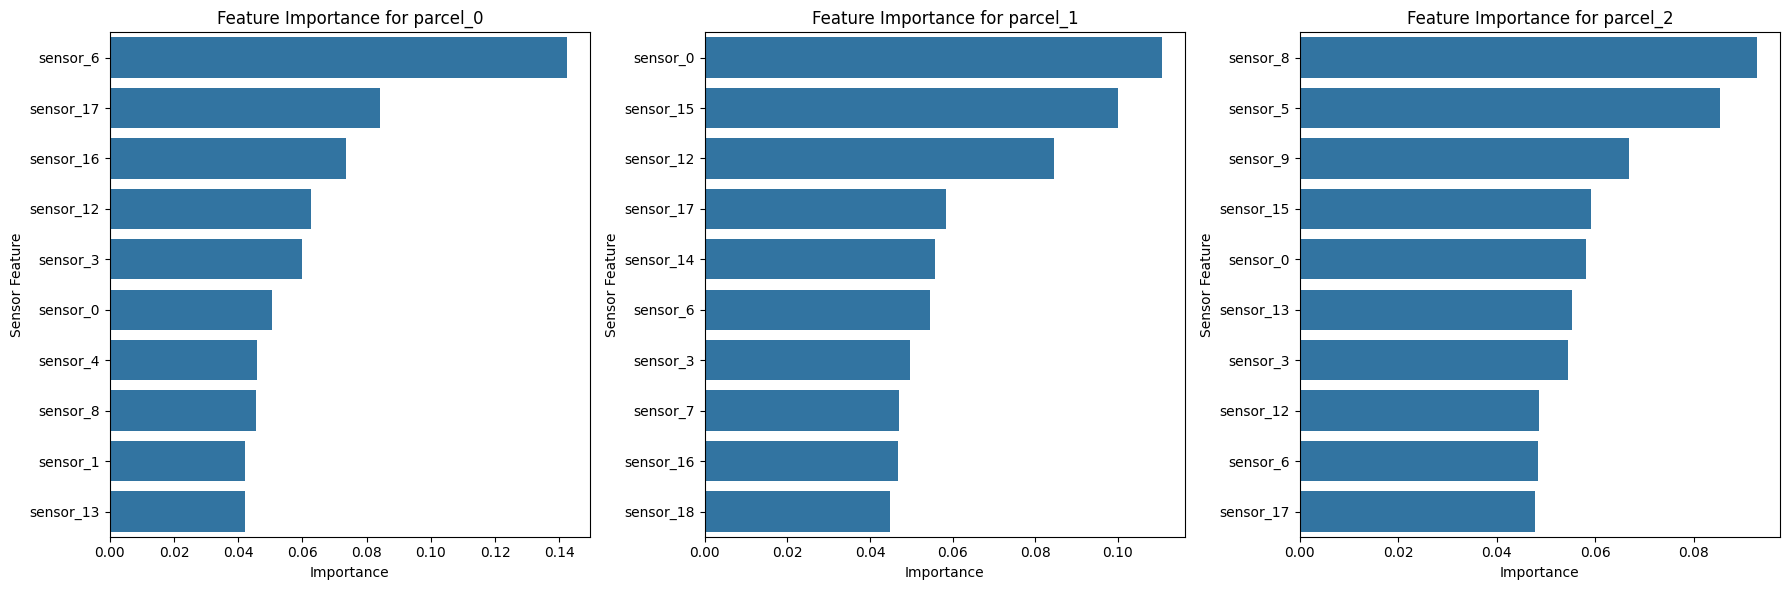


Model and scaler saved successfully.


In [1]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np

# Load the dataset (update the filename accordingly)
df = pd.read_csv("irrigation_machine.csv")

# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Display DataFrame information
print("\nDataFrame Information:")
df.info()

# Display column names
print("\nColumn Names:")
print(df.columns)

# Drop 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
print("\nDataFrame after dropping 'Unnamed: 0' column:")
print(df.head())

# Display descriptive statistics
print("\nDescriptive Statistics of the dataset:")
print(df.describe())

# Features (sensor readings)
X = df[[f'sensor_{i}' for i in range(20)]]

# Target variables (parcel irrigation status)
y = df[['parcel_0', 'parcel_1', 'parcel_2']]

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target variables (y): {y.shape}")

# --- Data Visualization ---

# Data Visualization: Bar graphs for target variables
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='parcel_0', data=df)
plt.title('Distribution of Parcel 0 Irrigation Status')
plt.xlabel('Parcel 0 Status')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(x='parcel_1', data=df)
plt.title('Distribution of Parcel 1 Irrigation Status')
plt.xlabel('Parcel 1 Status')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(x='parcel_2', data=df)
plt.title('Distribution of Parcel 2 Irrigation Status')
plt.xlabel('Parcel 2 Status')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Data Visualization: Sensor Data Distributions (Histograms/KDE)
print("\n--- Sensor Data Distributions ---")
num_sensors = X.shape[1]
# Determine grid size for subplots
cols = 4
rows = (num_sensors + cols - 1) // cols # Ceiling division
plt.figure(figsize=(cols * 4, rows * 3))
for i, col in enumerate(X.columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Data Visualization: Correlation Heatmap
plt.figure(figsize=(18, 15))
# Combine features and targets for correlation analysis
correlation_data = pd.concat([X, y], axis=1)
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sensor Readings and Parcel Status')
plt.show()

# --- Machine Learning Model ---

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to DataFrame (optional, but good for consistency)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the dataset into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the MultiOutputClassifier with RandomForestClassifier
multi_output_model = MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))
multi_output_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = multi_output_model.predict(X_test_scaled)

# Evaluate the model for each output
print("\n--- Model Evaluation ---")
for i, parcel_col in enumerate(y.columns):
    print(f"Classification Report for {parcel_col}:\n")
    print(classification_report(y_test[parcel_col], y_pred[:, i]))
    print("-" * 50)

# --- Feature Importance Plots for Each Parcel ---
print("\n--- Feature Importance Plots ---")
plt.figure(figsize=(18, 6))
for i, parcel_col in enumerate(y.columns):
    plt.subplot(1, 3, i + 1)
    # Get feature importances from the estimator for the current output
    importances = multi_output_model.estimators_[i].feature_importances_
    features_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=features_df.head(10)) # Top 10 features
    plt.title(f'Feature Importance for {parcel_col}')
    plt.xlabel('Importance')
    plt.ylabel('Sensor Feature')
plt.tight_layout()
plt.show()

# Save the trained model and scaler
joblib.dump(multi_output_model, 'multi_output_irrigation_model.joblib')
joblib.dump(scaler, 'min_max_scaler.joblib')

print("\nModel and scaler saved successfully.")